In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio, shuffle_split_testing, conformalized_quantile

In [4]:
import random
random.seed(42)
np.random.seed(42)
train_X, train_Y = generate_train_dataset(100)
env_X, env_Y = generate_calibration_dataset(10_000)

In [5]:
predictor = TrajectoryPredictor(0.1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0.5, 0.98, 'Training Trajectories')

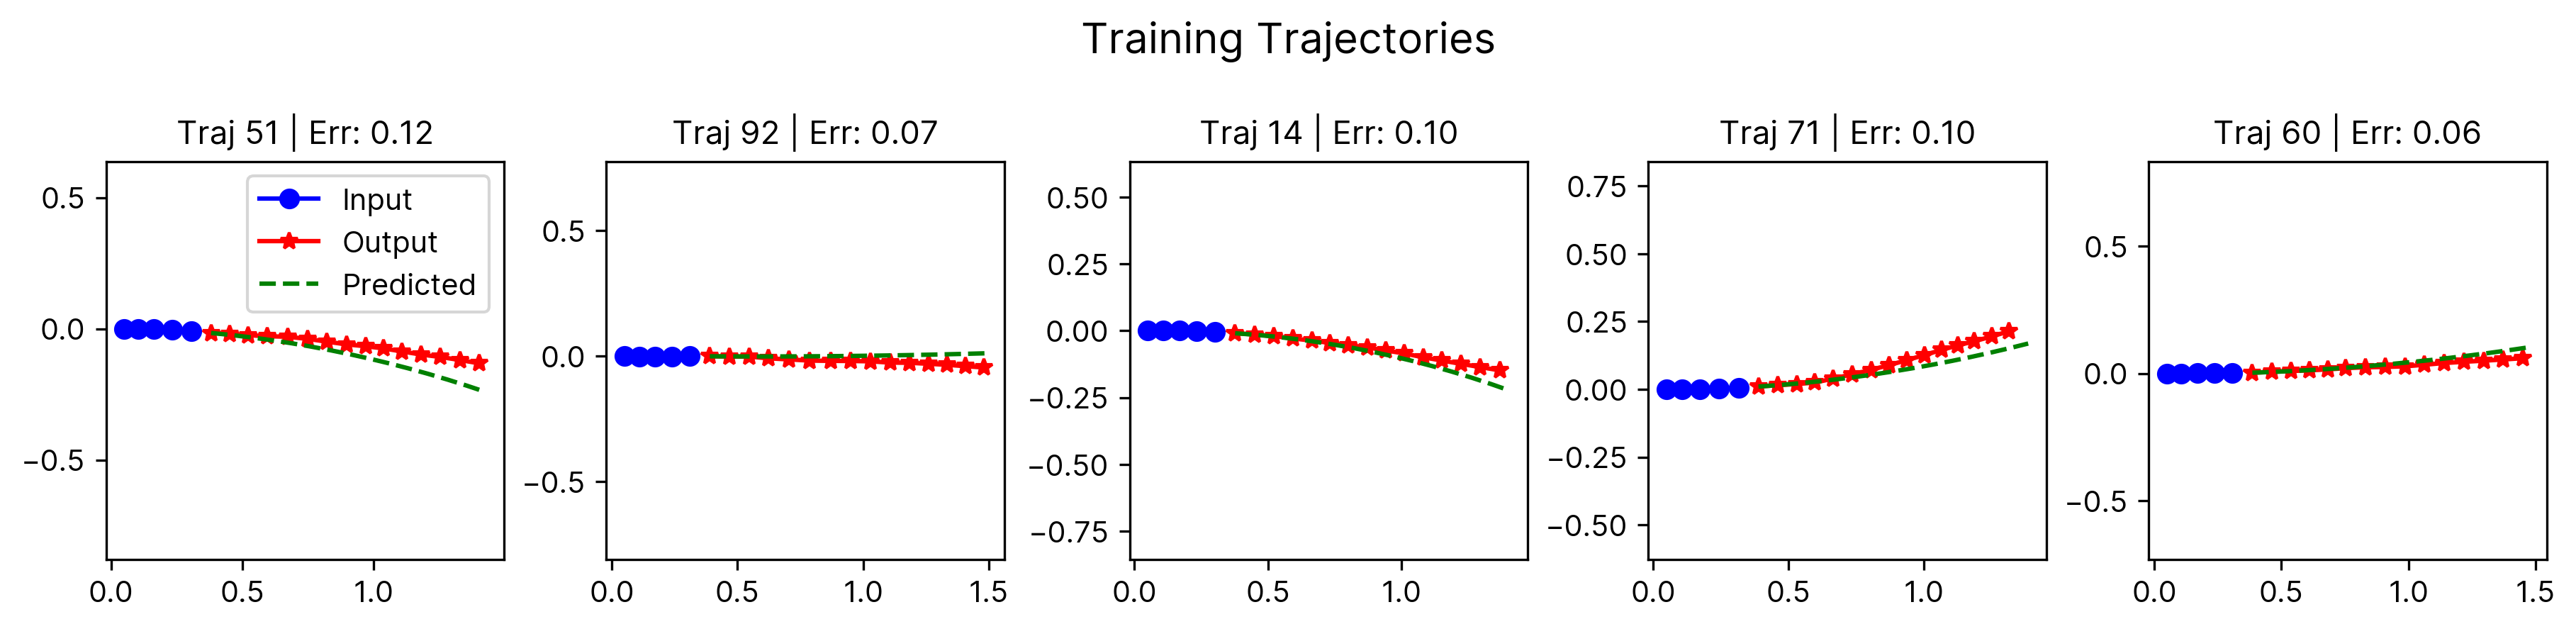

In [6]:
INDEX = np.random.choice(train_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

Text(0.5, 0.98, 'Calibration Distribution')

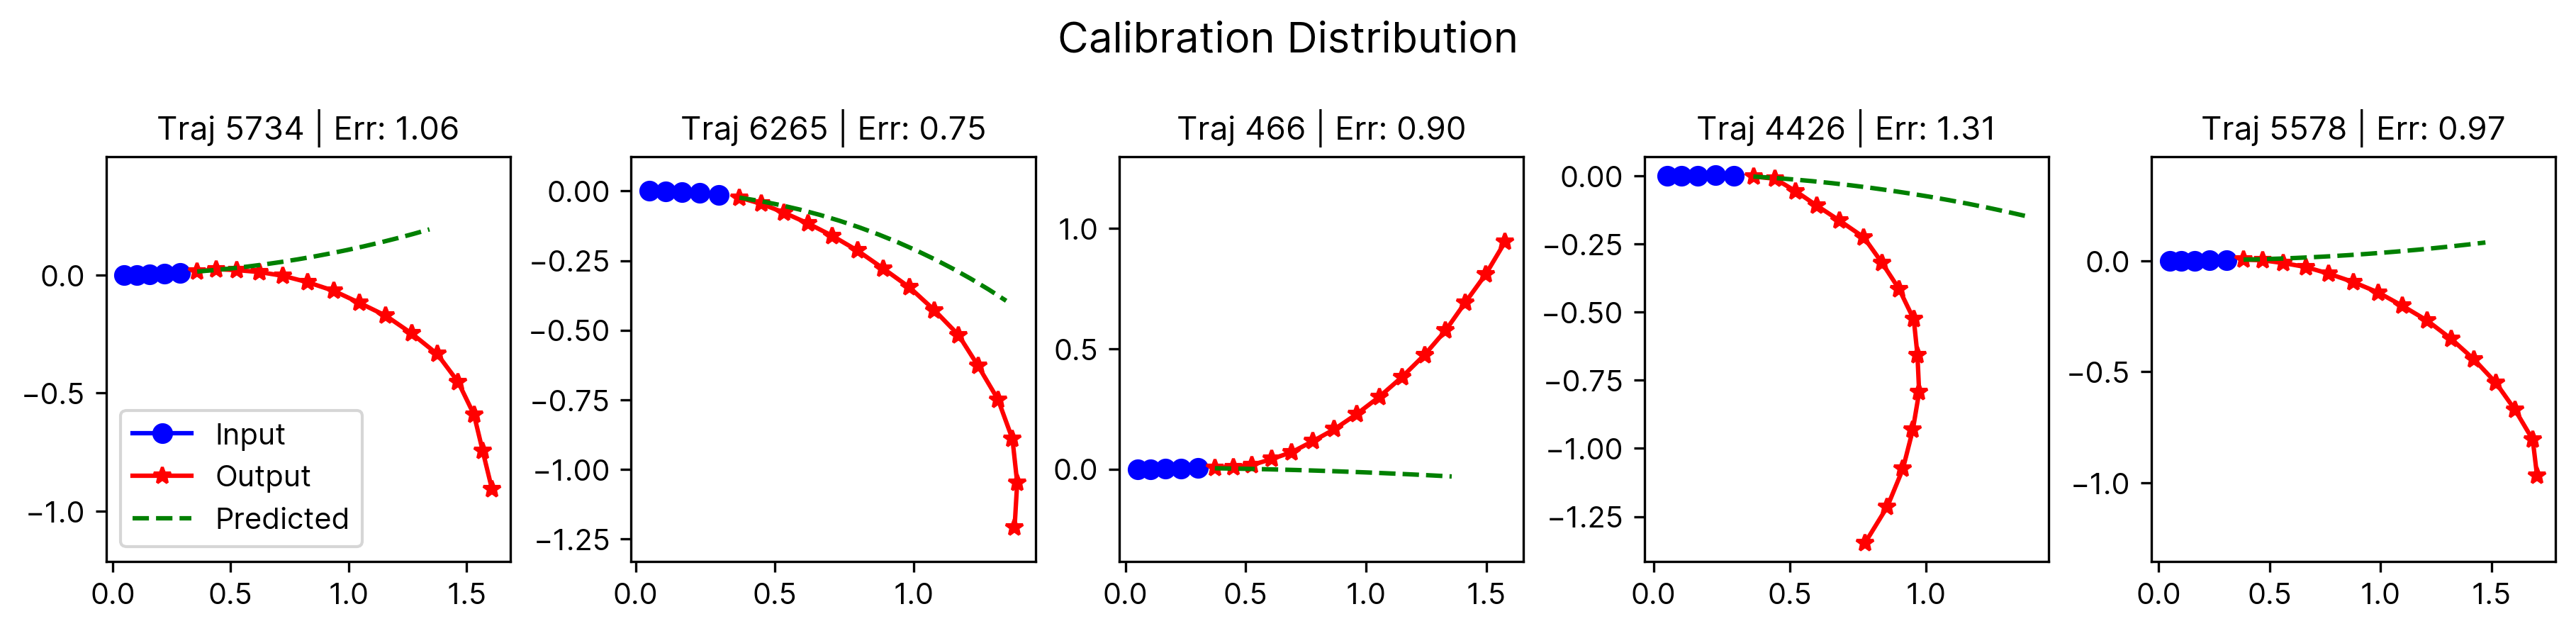

In [7]:
INDEX = np.random.choice(env_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Distribution')

In [8]:
TIMESTEPS = [5, 10, 14]
env_Y_hat = predictor.predict_batched_trajectories(env_X)
Z_env = env_Y[:,TIMESTEPS,:2] - env_Y_hat[:,TIMESTEPS,:2]
np.random.shuffle(Z_env)

In [9]:
Z_env.shape

(10000, 3, 2)

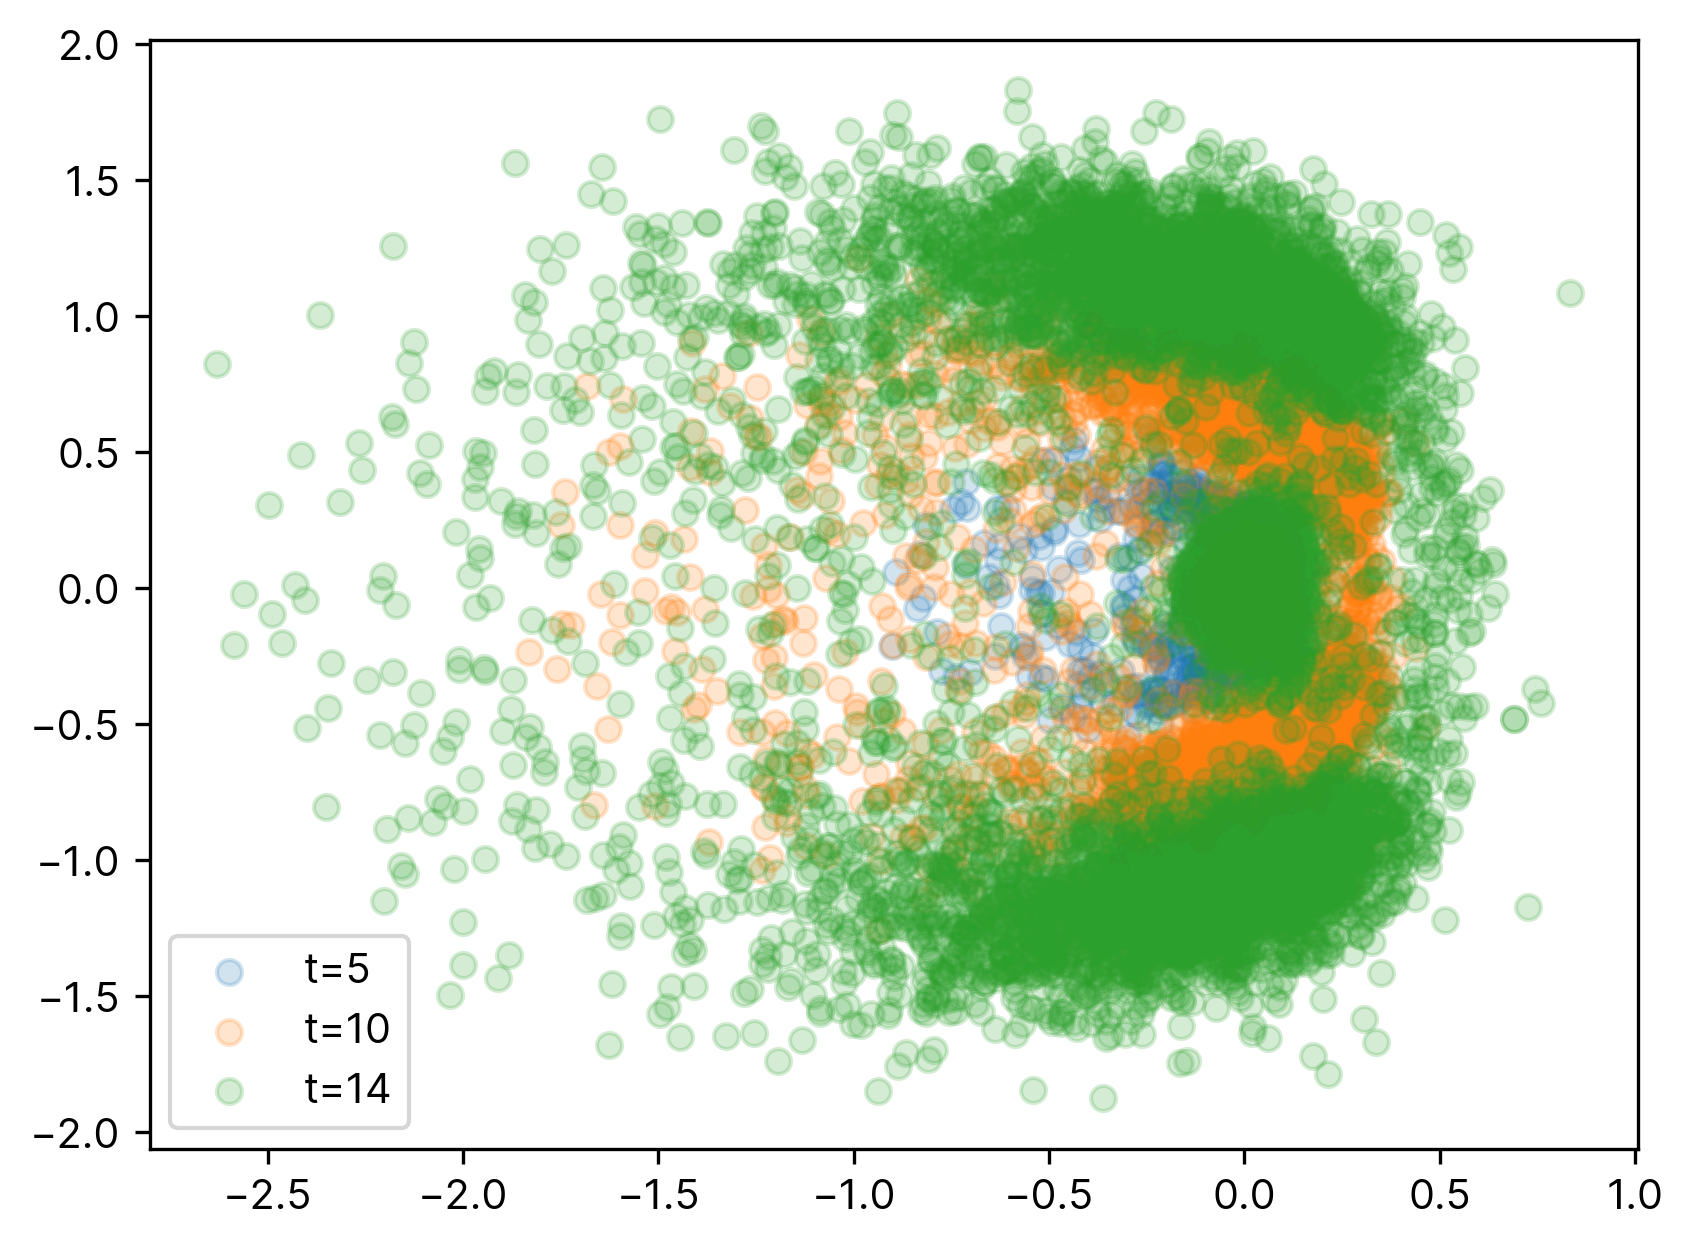

In [10]:
for i,ts in enumerate(TIMESTEPS):
    plt.scatter(Z_env[:,i,0], Z_env[:,i,1], alpha=0.2, label=f"t={ts}")
plt.legend()

# Use Parametrized Conformal Regions for Prediction

In [33]:
from conformal_region_designer.conformity_optimizer import ConformalRegionTimeSeries
DELTA = 0.90
BW_FACTOR = 0.3

In [34]:
Z_cal_one = Z_env[:Z_env.shape[0]//3]
Z_cal_two = Z_env[Z_env.shape[0]//3:2*(Z_env.shape[0]//3)]
Z_test = Z_env[2*(Z_env.shape[0]//3):]
Z_eval = Z_env[(Z_env.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 3, 2) (3333, 3, 2) (3334, 3, 2)


In [35]:
## Calculate benchmark CP region, based on L2 norm
## TODO: Rewrite with a unionbound based on the number of timesteps
bcp_scores_cal_one = [np.linalg.norm(Z_cal_one[:,0,:], axis=1), np.linalg.norm(Z_cal_one[:,1,:], axis=1)]
bcp_scores_cal_two = [np.linalg.norm(Z_cal_two[:,0,:], axis=1), np.linalg.norm(Z_cal_two[:,1,:], axis=1)]
bcp_scores_cal = [np.concatenate([bcp_scores_cal_one[i], bcp_scores_cal_two[i]]) for i in range(2)]
bcp_scores_test = [np.linalg.norm(Z_test[:,0,:], axis=1), np.linalg.norm(Z_test[:,1,:], axis=1)]
bcp_conformal_quantile = conformalized_quantile(len(bcp_scores_cal[0]), DELTA)
print(f'Conformal Quantile: {bcp_conformal_quantile:.2f}')
bcp_conformal_bound = [np.quantile(bcp_scores_cal[0], bcp_conformal_quantile), np.quantile(bcp_scores_cal[1], bcp_conformal_quantile)]
test_coverage = [(bcp_scores_test[i] < bcp_conformal_bound[i]).mean() for i in range(2)]
print(f'Coverage on test set: {test_coverage[0]:.4f}, {test_coverage[1]:.4f}')
print(f'Conformal Bound: {bcp_conformal_bound[0]:.2f} | Area: {np.pi * bcp_conformal_bound[0]**2:.2f}')
print(f'Conformal Bound: {bcp_conformal_bound[1]:.2f} | Area: {np.pi * bcp_conformal_bound[1]**2:.2f}')

Conformal Quantile: 0.90
Coverage on test set: 0.8986, 0.9004
Conformal Bound: 0.20 | Area: 0.12
Conformal Bound: 0.76 | Area: 1.80


## Convex Hull

In [36]:
from conformal_region_designer.density_estimation import KDE
de = KDE(grid_size=150, bw_factor=BW_FACTOR)

In [37]:
Z_cal_one.shape

(3333, 3, 2)

In [38]:
pcr = ConformalRegionTimeSeries(len(TIMESTEPS) ,de, "meanshift", "convexhull", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
cvxpcr = pcr

Total Weight Sum: 0.9627826477204502
Total Weight Sum: 0.9867003650197629
Total Weight Sum: 0.9867111102555967


Test Coverage:  0.8995200959808038


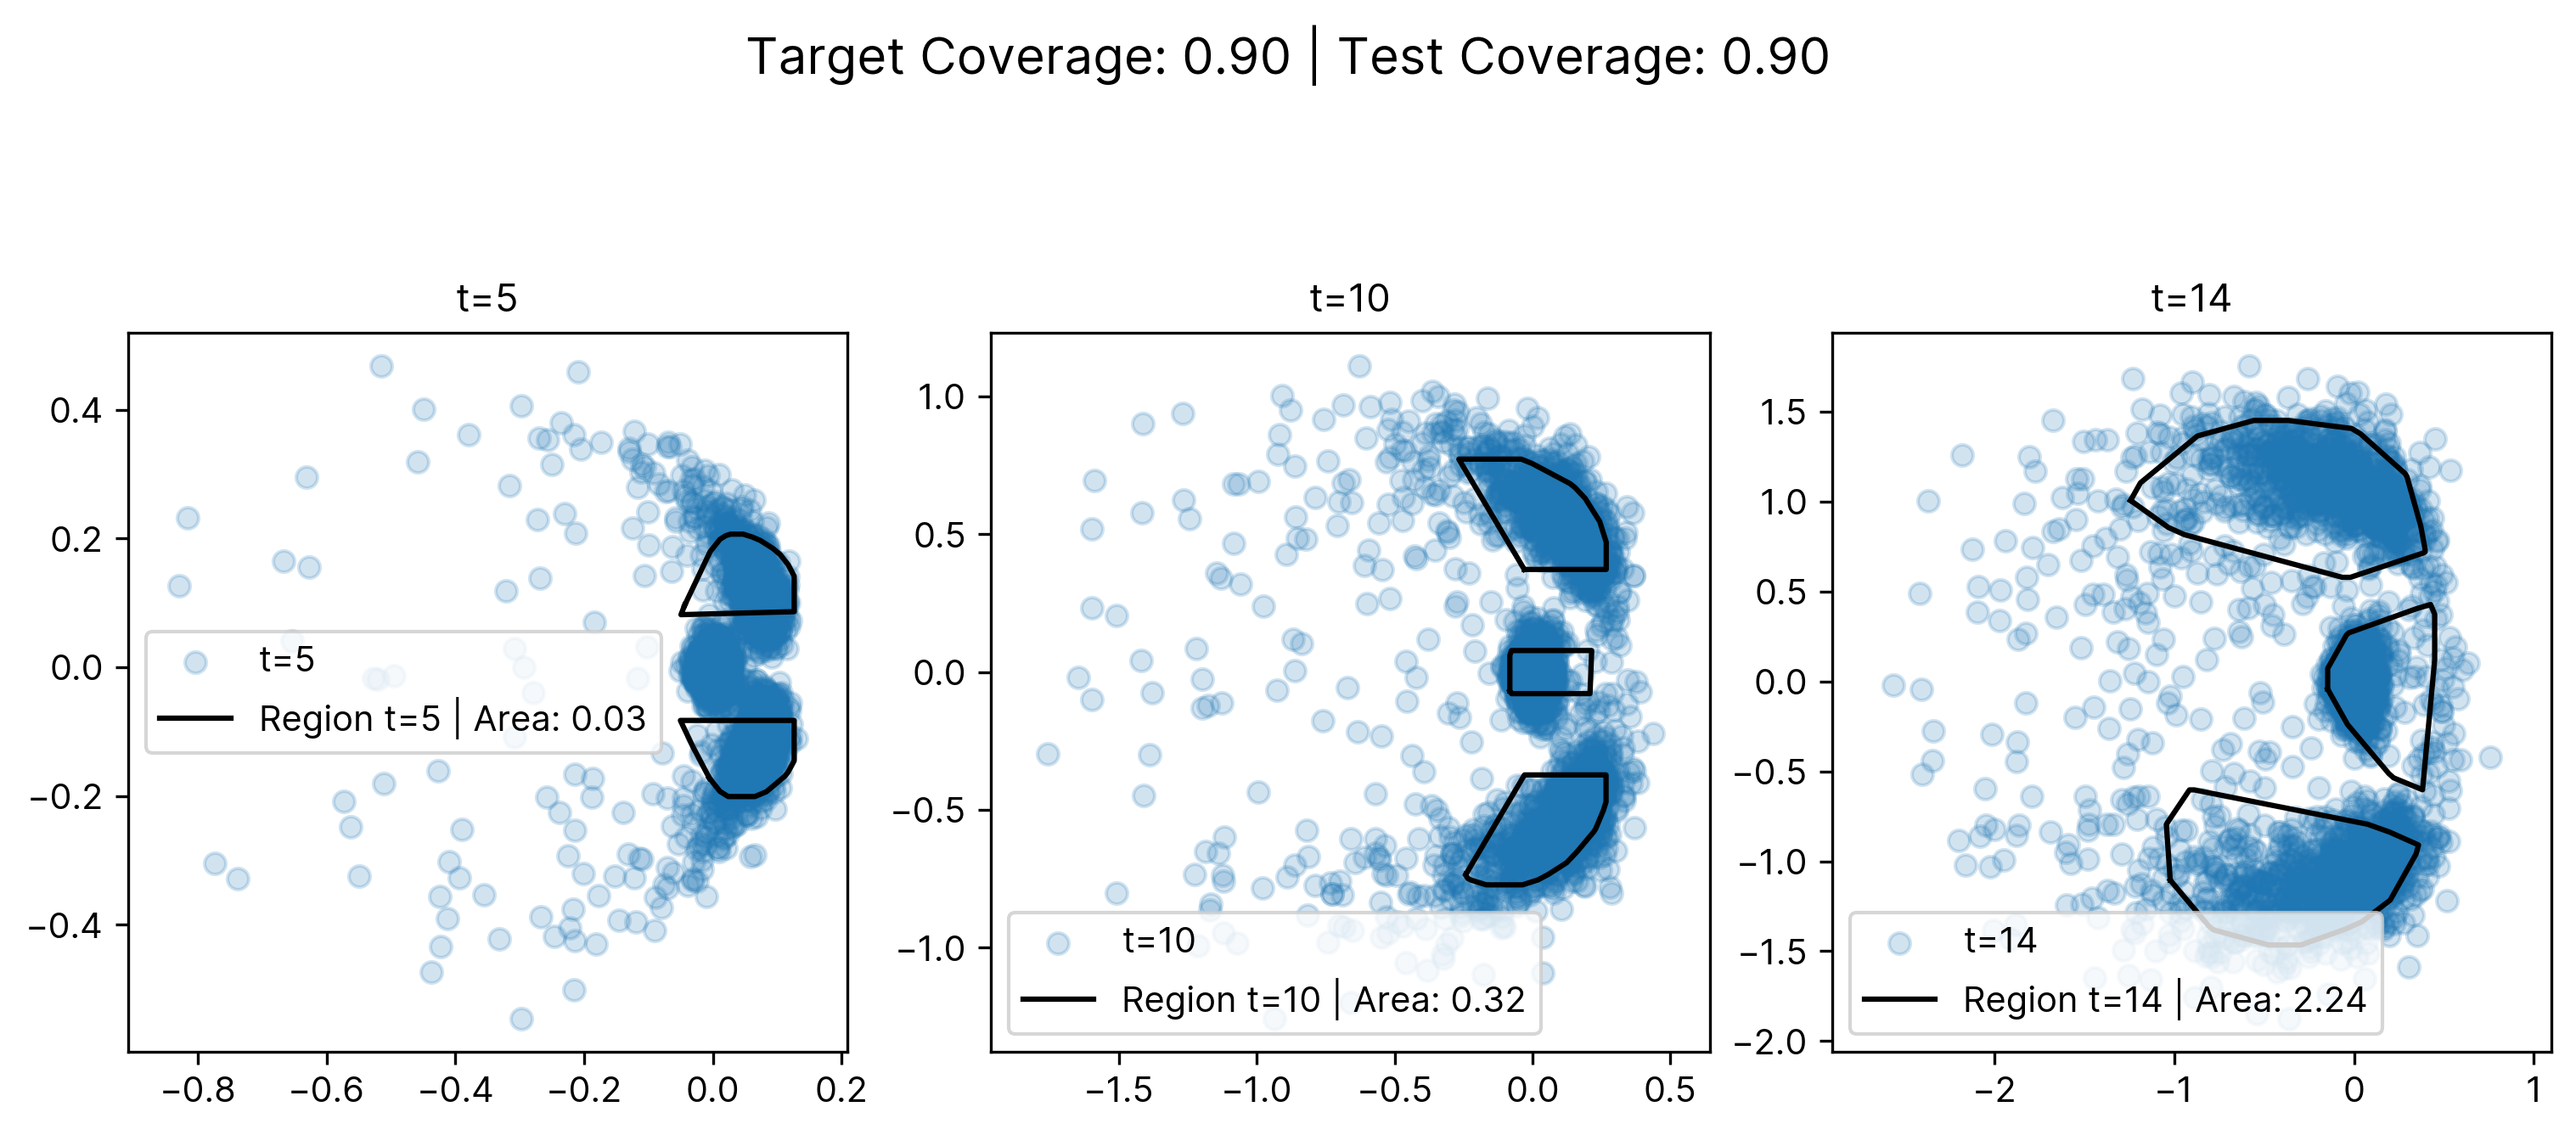

In [39]:
scores = cvxpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
cvx_coverage = coverage

fig, ax = plt.subplots(1, len(TIMESTEPS), constrained_layout=True, figsize=(10, 5), dpi=300)
for i, ts in enumerate(TIMESTEPS):
    ax[i].scatter(Z_test[:,i,0], Z_test[:,i,1], alpha=0.2, label=f"t={ts}")
    ts_area = 0
    for j, shape_template in enumerate(cvxpcr.cregions[i].shapes):
        ts_area += shape_template.volume()
        if j == len(cvxpcr.cregions[i].shapes) - 1:
            shape_template.plot(ax[i], label=f"Region t={ts} | Area: {ts_area:.2f}")
        else:
            shape_template.plot(ax[i])
    ax[i].set_title(f"t={ts}")
    ax[i].legend()
    set_square_aspect_ratio(ax[i])



# # Plot benchmark CP region
# bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
# ax.add_patch(bcp_cir)
# ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}');


TypeError: unsupported operand type(s) for +: 'int' and 'list'

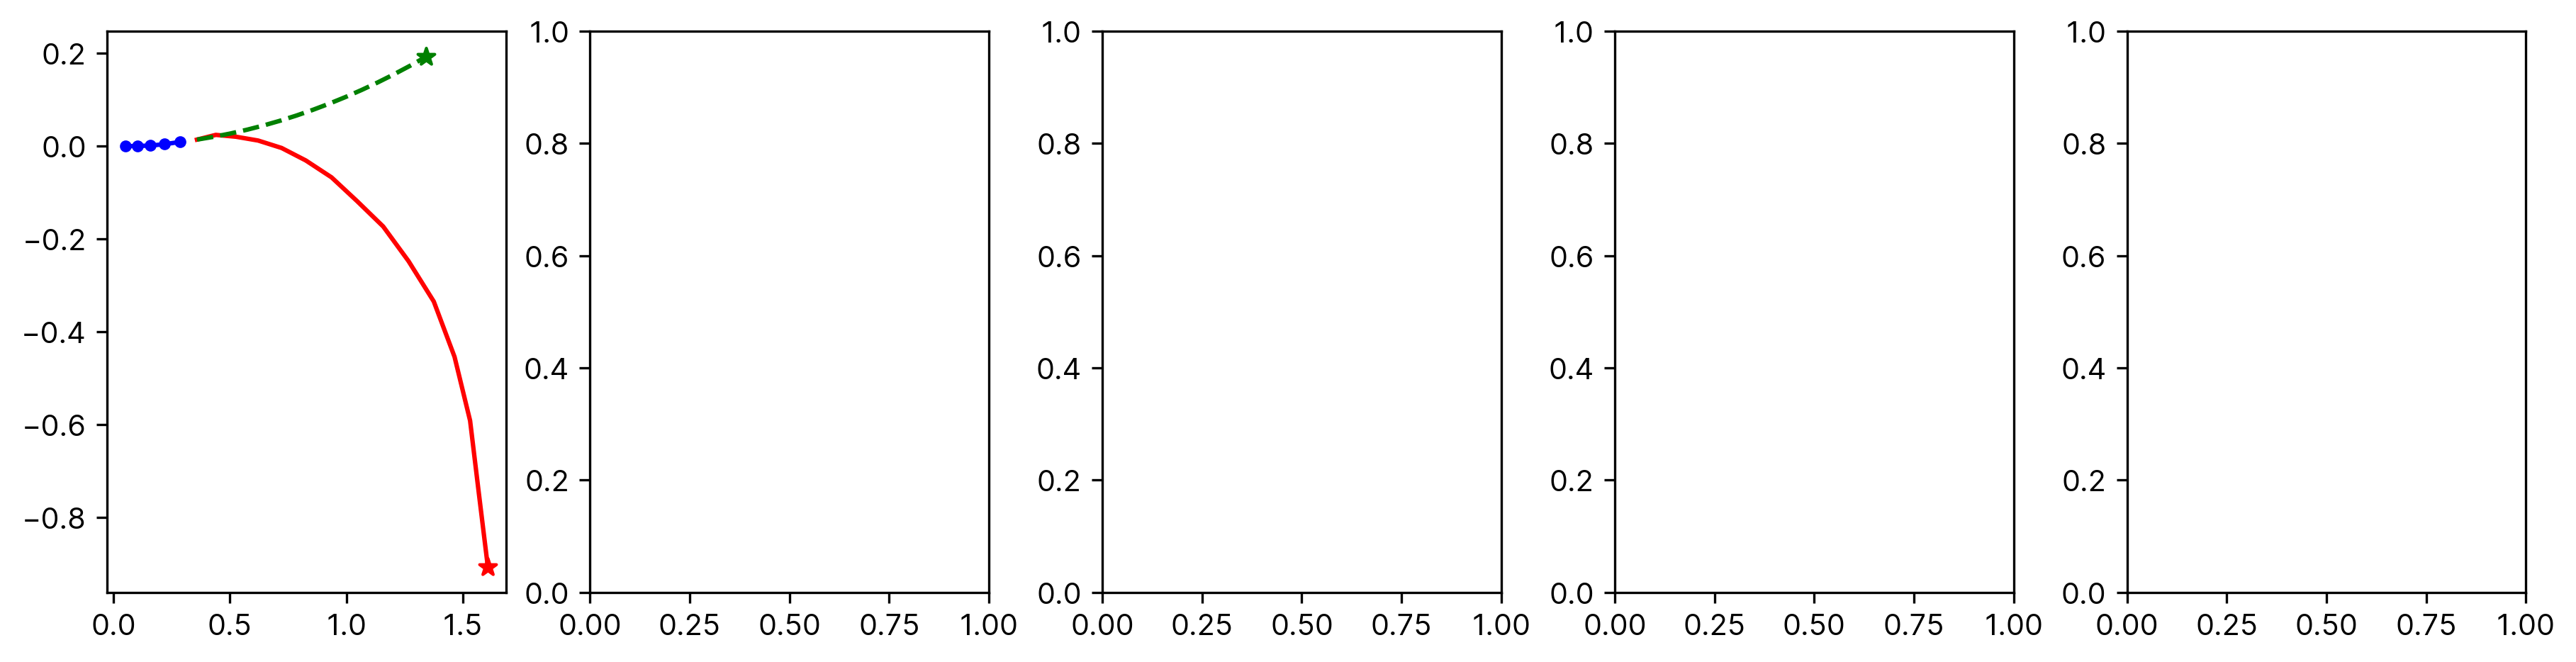

In [40]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in cvxpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    # Plot benchmark CP region
    bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    ax.add_patch(bcp_cir)
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Convex Hull Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

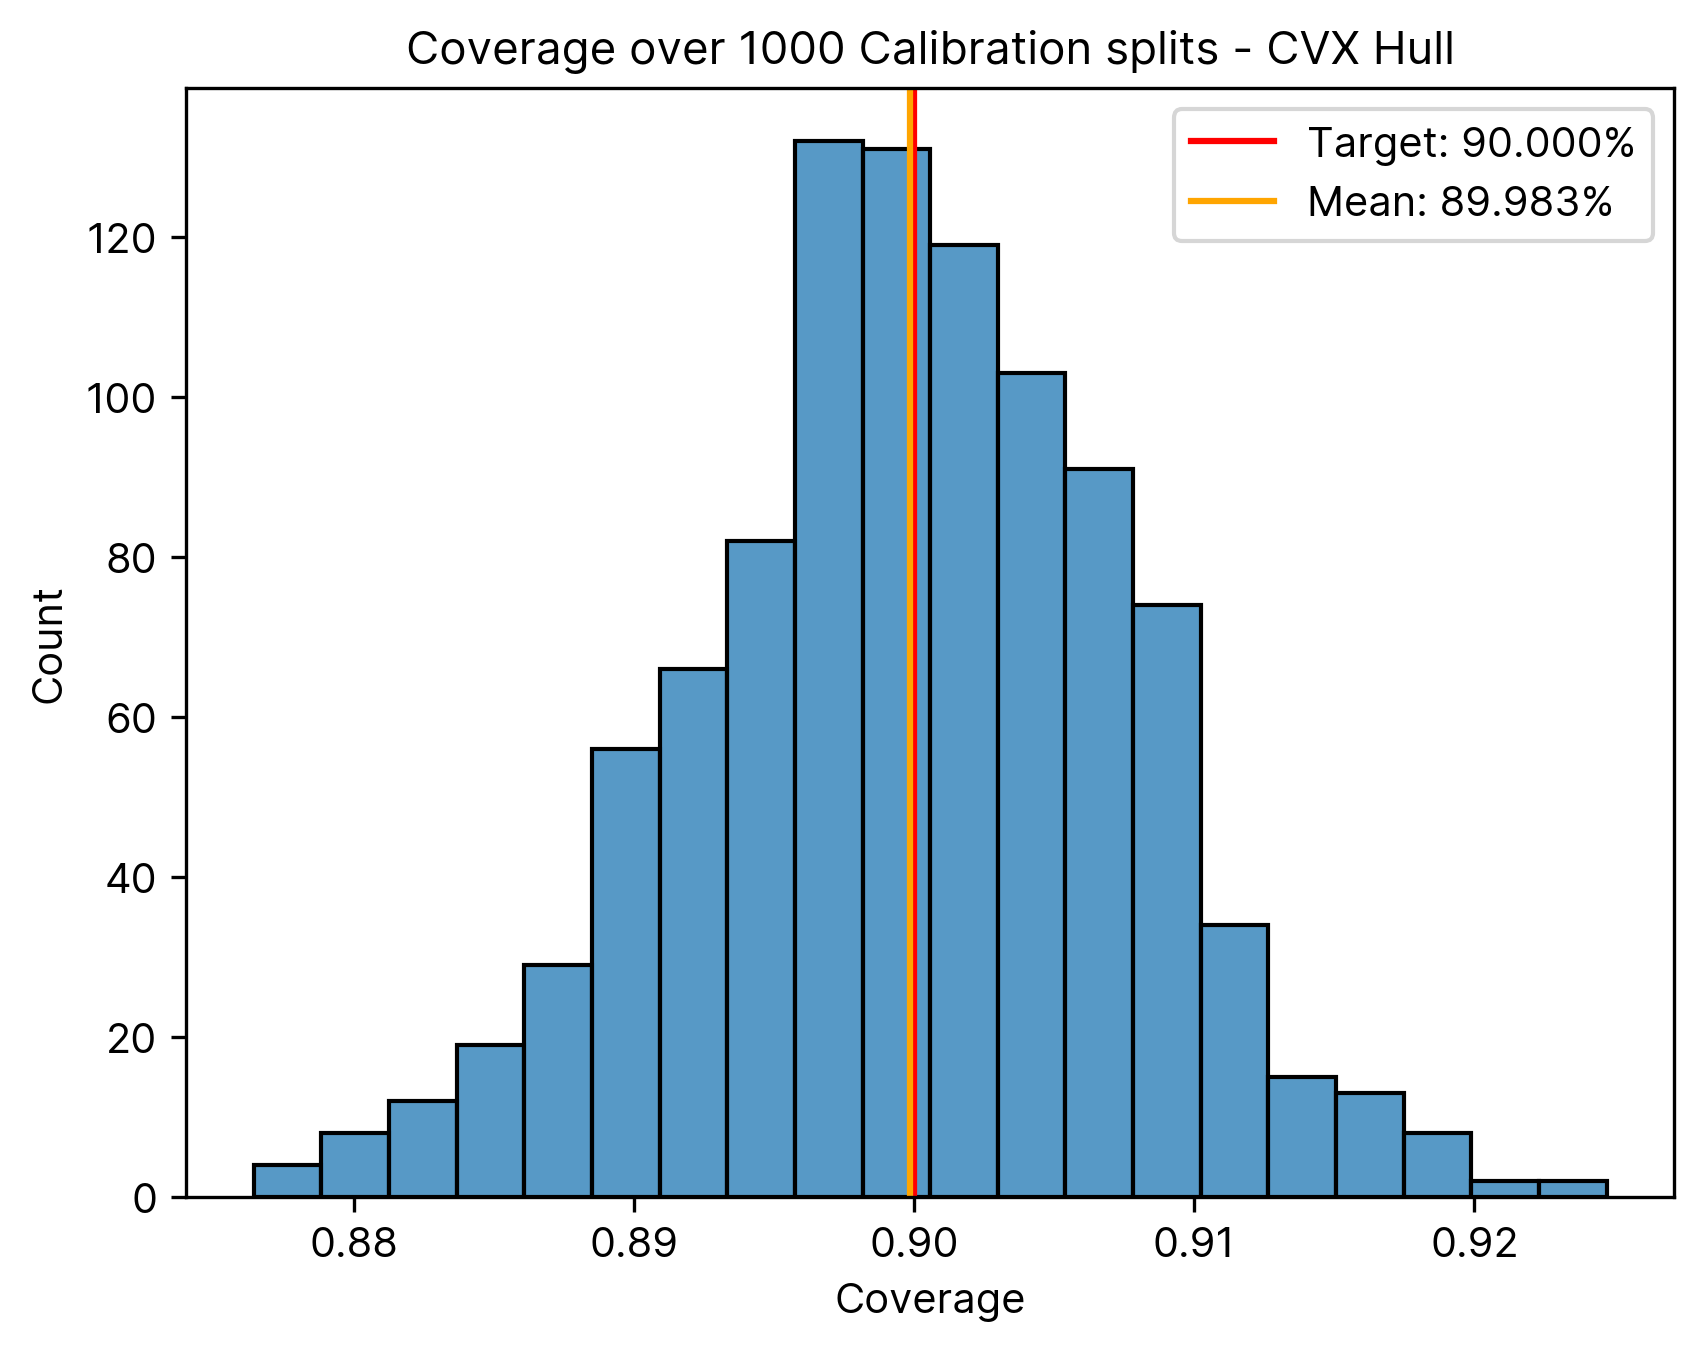

In [42]:
cvxcoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)

sns.histplot(cvxcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(cvxcoverages), color="orange", label=f"Mean: {np.mean(cvxcoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - CVX Hull")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Hyperrectangle

In [ ]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "hyperrectangle", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
hrcpcr = pcr

In [ ]:
scores = hrcpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
hrc_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(hrcpcr.shapes):
    total_area += shape_template.volume()
    if i == len(hrcpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in hrcpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    # Plot benchmark CP region
    bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle=':', fill=False, label='Benchmark CP')
    ax.add_patch(bcp_cir)
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Hyperrectangle Prediction Region for Endpoint')

In [ ]:
hrccoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(hrccoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(hrccoverages), color="orange", label=f"Mean: {np.mean(hrccoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - HypRect")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Ellipsoid

In [ ]:
de = KDE(grid_size=150, bw_factor=BW_FACTOR)
pcr = ConformalRegion(de, "meanshift", "ellipse", DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
ellpcr = pcr
print(pcr.normalizing_constant)

In [ ]:
scores = ellpcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)
ell_coverage = coverage

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(ax, label="Prediction Region | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(ax)
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
ax.add_patch(bcp_cir)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in ellpcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    # Plot benchmark CP region
    bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'Benchmark Region | Area: {np.pi * bcp_conformal_bound**2:.2f}')
    ax.add_patch(bcp_cir)
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Ellipsoid Prediction Region for Endpoint')

In [ ]:
ellcoverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(ellcoverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(ellcoverages), color="orange", label=f"Mean: {np.mean(ellcoverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - Ellipse")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
sns.kdeplot(x=Z_cal_one[:,0], y=Z_cal_one[:, 1], fill=True, ax=ax, label='Calibration Set 1', alpha=0.5)
sns.kdeplot(x=Z_cal_two[:,0], y=Z_cal_two[:, 1], fill=True, ax=ax, label='Calibration Set 2', alpha=0.5)
plt.scatter(Z_test[:,0], Z_test[:,1], label='Test Set', alpha=0.2, marker='.')
# Plot the density estimator min and max
ax.plot(
    [pcr.de.min[0], pcr.de.min[0], pcr.de.max[0], pcr.de.max[0], pcr.de.min[0]],
    [pcr.de.min[1], pcr.de.max[1], pcr.de.max[1], pcr.de.min[1], pcr.de.min[1]],
    color="black",
)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
# On the first plot, show the convex hull
#ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
axs[0].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[0].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(cvxpcr.shapes):
    total_area += shape_template.volume()
    if i == len(cvxpcr.shapes) - 1:
        shape_template.plot(axs[0], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[0])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[0].add_patch(bcp_cir)
axs[0].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
set_square_aspect_ratio(axs[0])
axs[0].set_title('Convex Hull Prediction Regions')

axs[1].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[1].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(hrcpcr.shapes):
    total_area += shape_template.volume()
    if i == len(hrcpcr.shapes) - 1:
        shape_template.plot(axs[1], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[1])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[1].add_patch(bcp_cir)
axs[1].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
set_square_aspect_ratio(axs[1])
axs[1].set_title('Hyperrectangle Prediction Regions')

axs[2].scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="$Z_{\\text{test}}$", alpha=0.2)
axs[2].set_aspect("equal")
total_area = 0
for i, shape_template in enumerate(ellpcr.shapes):
    total_area += shape_template.volume()
    if i == len(ellpcr.shapes) - 1:
        shape_template.plot(axs[2], label="$S_{{CP}}$ | Area: {:.2f}".format(total_area))
    else:
        shape_template.plot(axs[2])
# Plot benchmark CP region
bcp_cir = plt.Circle((0,0), bcp_conformal_bound, color='red', linestyle='--', fill=False, label=f'$S_{{\\text{{benchmark}}}}$ | Area: {np.pi * bcp_conformal_bound**2:.2f}')
axs[2].add_patch(bcp_cir)
axs[2].legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', borderaxespad=0.)
axs[2].set_title('Ellipsoid Prediction Regions')
set_square_aspect_ratio(axs[2])

fig.suptitle("Vehicle Trajectory Prediction Regions")

In [ ]:
fig = plt.figure(figsize=(10, 3.5))
from matplotlib import gridspec
gs = gridspec.GridSpec(1,10)
ax1 = plt.subplot(gs[0, :6])
ax2 = plt.subplot(gs[0, 6:])

sns.histplot(cvxcoverages, element="poly", label="Convex Hull", alpha=0.3, ax=ax1)
sns.histplot(hrccoverages, element="poly", label="Hyperrectangle", alpha=0.3, ax=ax1)
sns.histplot(ellcoverages, element="poly", label="Ellipsoid", alpha=0.3, ax=ax1)
ax1.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
ax1.legend()
ax1.set_title("(a) Coverage over 1000 random splits")

i=1
prediction = predictor.predict_trajectory(env_X[INDEX[i]])
ax2.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
ax2.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
ax2.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
ax2.plot(prediction[:, 0], prediction[:, 1], 'g--')
ax2.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
for shape_template in cvxpcr.shapes:
    shape_template.plot(ax2, offset_coords=prediction[-1])
ax2.set_title(f'(b) Visualized Region')
# Plot benchmark CP region
bcp_cir = plt.Circle(prediction[-1], bcp_conformal_bound, color='orange', linestyle='--', fill=False, label='Benchmark CP')
ax2.add_patch(bcp_cir)
set_square_aspect_ratio(ax2)
ax2.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), borderaxespad=0.)
ax2.set_xticks([])
ax2.set_yticks([])
# Zoom out of ax2
# RANGE = 3
# CENTER = [0,-1]
# ax2.set_xlim(CENTER[0]-RANGE, CENTER[0]+RANGE)
# ax2.set_ylim(CENTER[1]-RANGE, CENTER[1]+RANGE)